In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv"
df = pd.read_csv(url)

In [3]:
# Display the first few rows of the dataset
print(df.head())

         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  


In [4]:
df.shape

(2035, 8)

In [5]:
# Use the 'Close' column for prediction
data = df.filter(['Close']).values
dataset = data.reshape(-1, 1)

In [6]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
# Split the dataset into training and testing sets
train_data_len = int(np.ceil(len(dataset) * .95))
train_data = scaled_data[0:int(train_data_len), :]

In [8]:
# Create the training data set
x_train, y_train = [], []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


In [9]:
# Reshape the data to be 3-dimensional for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1874/1874 [==============================] - 59s 29ms/step - loss: 0.0016


In [13]:
# Create the testing data set
test_data = scaled_data[train_data_len - 60:, :]

In [14]:
# Create the data sets x_test and y_test
x_test, y_test = [], dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [15]:
# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape the data to be 3-dimensional for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 24ms/step


In [17]:
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 6.018089194929748


<ipython-input-18-0f99ffe3188f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


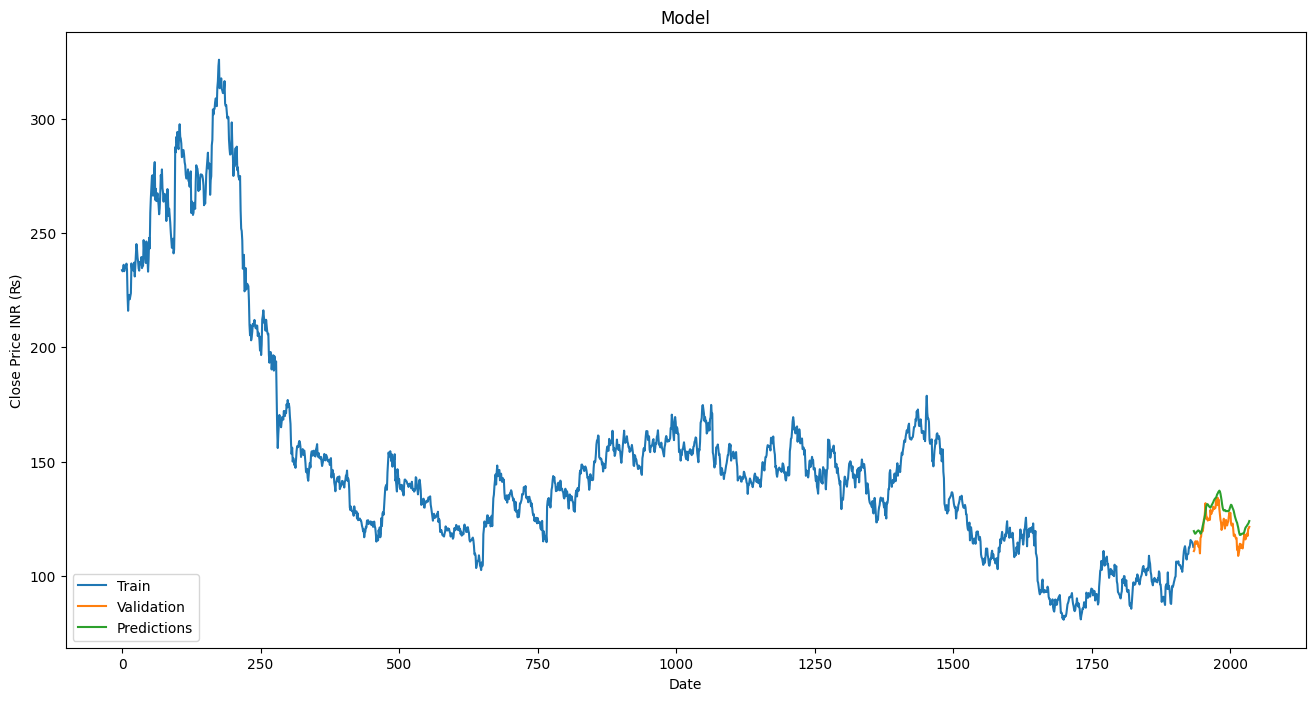

In [18]:
# Plot the data
train = df[:train_data_len]
valid = df[train_data_len:]
valid['Predictions'] = predictions

# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₨)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower left')
plt.show()


# Thank You